# <span style="color:DarkOliveGreen">Support Vector Regression Forecast of CDX.NA.IG

__Summary:__ <span style="color:Blue">Use SVR model to fit and predict

In [1]:
# Import required libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score


# importing libraries
from xbbg import blp, pipeline
import yfinance as yf
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from datetime import date, timedelta

import matplotlib.dates as mdates
import datetime
from datetime import datetime
from pandas.tseries.offsets import BDay

import os
np.random.seed(0)

In [2]:
# User defined names
index = "CDX.NA.IG"
filename = "input_data.csv"
date_col = "Date"

In [3]:
# Get current working directory
mycwd = os.getcwd()
print(mycwd)

C:\Users\rsingh\Desktop\WorldQuant\Capstone\Draft Submission\MScFE_Capstone-main\Notebooks


In [4]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Data")

#### <span style="color:DarkOliveGreen">Read input data as df:

In [5]:
# Read the data
df = pd.read_csv(filename, index_col=date_col)
#df.index = pd.to_datetime(df.index)
df.head()

,IG_BO,SPX,VIX,UST_3M,UST_6M,UST_1Y,UST_2Y,UST_3Y,UST_5Y,UST_7Y,UST_10Y,UST_20Y,UST_30Y,IG_MID
Date,,,,,,,,,,,,,,
2012-01-01,1.500,1257.61,23.40,0.02,0.06,0.12,0.25,0.36,0.83,1.35,1.89,2.57,2.89,120.000
2012-01-02,1.500,1257.61,23.40,0.02,0.06,0.12,0.25,0.36,0.83,1.35,1.89,2.57,2.89,120.000
2012-01-03,1.000,1277.06,22.97,0.02,0.06,0.12,0.27,0.40,0.89,1.41,1.97,2.67,2.98,118.000
2012-01-04,1.000,1277.30,22.22,0.02,0.06,0.12,0.25,0.40,0.89,1.43,2.00,2.71,3.03,118.750
2012-01-05,0.917,1281.06,21.48,0.02,0.07,0.11,0.27,0.40,0.88,1.43,2.02,2.74,3.06,120.001


In [6]:
print("shape:",df.shape)
print("first date:",df.index[0])
print("last date:",df.index[-1])

shape: (4018, 14)
first date: 2012-01-01
last date: 2022-12-31


#### <span style="color:DarkOliveGreen">Plotting our data and rolling mean:

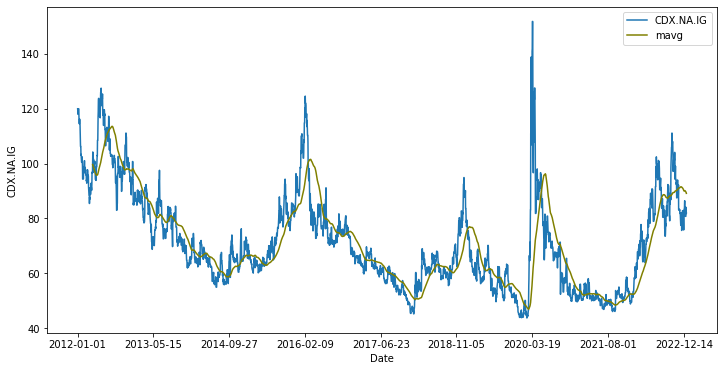

In [7]:
# Visualize the training stock data:
%matplotlib inline

# Rolling mean
close_px = df['IG_MID']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='CDX.NA.IG')
mavg.plot(label='mavg',color='olive')
plt.xlabel('Date')
plt.ylabel('CDX.NA.IG')
plt.legend()

#### <span style="color:DarkOliveGreen">User-defined Functions

In [8]:
'''Function to evaluate a SVR model with chosen parameters to help with hyper-parameter optimization'''
'''The output is a chosen performance metric i.e. rmse and a plot for model loss vs epochs'''
def run_svr(X_train, y_train, C, epsilon, gamma, show_plots):
    # Build the model 
    svr_model = SVR(kernel= 'rbf', C=C, epsilon=epsilon, gamma= gamma)
    svr_model.fit(X_train, y_train)
        
    # Fit the prices with the model
    fitted_y = svr_model.predict(X_train)
    
    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_train, fitted_y))
    print('Fit RMSE: %.3f' % rmse)
    
    # plot the results
     
    if show_plots:
        plt.figure(figsize = (10,6))
        plt.plot(y_train, color = 'blue', label = 'CDX.NA.IG')
        plt.plot(fitted_y, color = 'olive', label = 'Fitted CDX.NA.IG')

        plt.xlabel('Time')
        plt.ylabel('CDX.NA.IG')
        plt.legend()
        plt.show()
        
    return rmse

 #### <span style="color:DarkOliveGreen"> Preparing Data for feeding to SVR model.

In [9]:
import matplotlib.dates as mdates

# change the dates into ints for training 
dates_df = df.copy()
dates_df = dates_df.reset_index()

# Store the original dates for plotting the predicitons
org_dates = dates_df['Date']

# convert to ints
dates_df['DateNum'] = [mdates.datestr2num(dt) for dt in dates_df['Date']]

dates_df.tail()

,Date,IG_BO,SPX,VIX,UST_3M,UST_6M,UST_1Y,UST_2Y,UST_3Y,UST_5Y,UST_7Y,UST_10Y,UST_20Y,UST_30Y,IG_MID,DateNum
4013,2022-12-27,0.617,3829.25,21.65,4.46,4.76,4.75,4.32,4.17,3.94,3.93,3.84,4.10,3.93,80.753,19353.0
4014,2022-12-28,0.907,3783.22,22.14,4.46,4.75,4.71,4.31,4.18,3.97,3.97,3.88,4.13,3.98,84.111,19354.0
4015,2022-12-29,0.632,3849.28,21.44,4.45,4.73,4.71,4.34,4.16,3.94,3.91,3.83,4.09,3.92,81.710,19355.0
4016,2022-12-30,1.302,3839.50,21.67,4.42,4.76,4.73,4.41,4.22,3.99,3.96,3.88,4.14,3.97,82.024,19356.0
4017,2022-12-31,1.302,3839.50,21.67,4.42,4.76,4.73,4.41,4.22,3.99,3.96,3.88,4.14,3.97,82.024,19357.0


 #### <span style="color:DarkOliveGreen"> Splitting data as training and testing set:

In [10]:
train_df, test_df = train_test_split(dates_df, test_size=0.1, shuffle=False)

X_train = np.array(train_df['DateNum'])
y_train =  np.array(train_df['IG_MID'])

X_test = np.array(test_df['DateNum'])
y_test =  np.array(test_df['IG_MID'])


#Convert to 1d Vector
X_train = np.reshape(X_train, (len(X_train), 1))
y_train = np.reshape(y_train, (len(y_train), 1))

X_test = np.reshape(X_test, (len(X_test), 1))
y_test = np.reshape(y_test, (len(y_test), 1))

 #### <span style="color:DarkOliveGreen"> Building the SVR model:

In [11]:
# Use sklearn support vector regression to predicit our data:
from sklearn.svm import SVR

svr_model = SVR(kernel= 'rbf', C= 1e3, epsilon=0.01, gamma= 0.1)
svr_model.fit(X_train, y_train)

SVR(C=1000.0, epsilon=0.01, gamma=0.1)

In [12]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_train, svr_model.predict(X_train)))
print('Training Fit RMSE: %.3f' % rmse)

rmse = np.sqrt(mean_squared_error(y_test, svr_model.predict(X_test)))
print('Test Fit RMSE: %.3f' % rmse)

Training Fit RMSE: 0.901
Test Fit RMSE: 16.973


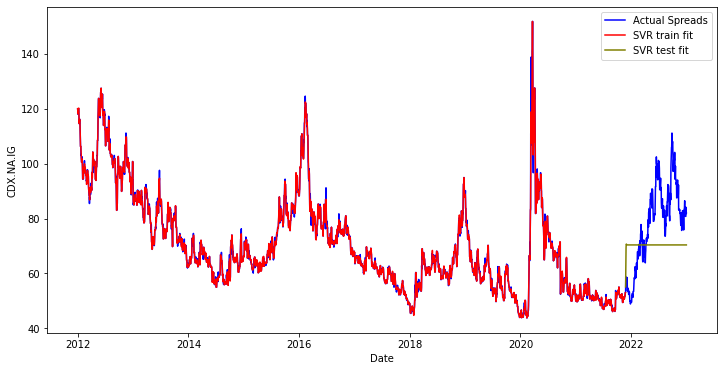

In [13]:
dates = [datetime.strptime(dt, '%Y-%m-%d').date() for dt in dates_df['Date']]
train_dates = [datetime.strptime(dt, '%Y-%m-%d').date() for dt in train_df['Date']]
test_dates = [datetime.strptime(dt, '%Y-%m-%d').date() for dt in test_df['Date']]

plt.figure(figsize = (12,6))
plt.plot(dates,dates_df['IG_MID'], color= 'blue', label= 'Actual Spreads')

plt.plot(train_dates, svr_model.predict(X_train), color= 'red', label= 'SVR train fit')
plt.plot(test_dates, svr_model.predict(X_test), color= 'olive', label= 'SVR test fit')

plt.xlabel('Date')
plt.ylabel('CDX.NA.IG')
plt.legend()
plt.show()

### <span style="color:DarkOliveGreen">Save the Data

In [15]:
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Data")

In [30]:
train_res = pd.DataFrame(index=train_dates)
train_res['IG_MID'] = train_df['IG_MID'].values
train_res['svm_fit'] = svr_model.predict(X_train)
train_res.to_csv("svm_train_res"+".csv", index=True)

In [31]:
train_res.head()

,IG_MID,svm_fit
2012-01-01,120.000,120.009851
2012-01-02,120.000,119.989742
2012-01-03,118.000,118.137969
2012-01-04,118.750,118.740485
2012-01-05,120.001,119.997760


In [32]:
test_res = pd.DataFrame(index=test_dates)
test_res['IG_MID'] = test_df['IG_MID'].values
test_res['svm_predict'] = svr_model.predict(X_test)
test_res.to_csv("svm_test_res"+".csv", index=True)

In [33]:
test_res.head()

,IG_MID,svm_predict
2021-11-25,53.020,55.060512
2021-11-26,57.454,60.078426
2021-11-27,57.454,65.667874
2021-11-28,57.454,69.262382
2021-11-29,55.083,70.565937


### <span style="color:DarkOliveGreen">Performing grid-search CV

In [ ]:
# We are going to use GridSearchCV method
# for getting best parameters for our model
# first we will provide some parameters as Dict here
parameters = {
        'C':[0.001,0.01,0.1,1,100,1000],
        'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,  50, 100, 150, 1000],
        'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5, 8, 40, 100, 1000]
    }

# we will use Support Vector Regressor and kernel as Radial Basis Function
gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid=parameters,
        cv=10,
        scoring='neg_mean_absolute_error'
    )

grid_result = gsc.fit(X_train, y_train)

# storing and using best parameters
# best parameters = min error
best_param = grid_result.best_params_
svr_model = SVR(kernel='rbf', C=best_param['C'], epsilon=best_param['epsilon'], gamma=best_param['gamma'])
svr_model.fit(X_train, y_train)

In [ ]:
svr_model = SVR(kernel='rbf', C=1000, epsilon=0.01, gamma=.01)
svr_model.fit(X_train, y_train)

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(dates,dates_df['IG_MID'], color= 'blue', label= 'Actual Spreads')

plt.plot(train_dates, svr_model.predict(X_train), color= 'red', label= 'SVR train fit')
plt.plot(test_dates, svr_model.predict(X_test), color= 'olive', label= 'SVR test fit')

plt.xlabel('Date')
plt.ylabel('CDX.NA.IG')
plt.legend()
plt.show()

 ### <span style="color:DarkOliveGreen">Performing Parameter Hypertuning: Gamma

In [ ]:
gamma1 = 0.1
gamma2 = 0.01
gamma3 = 0.001
gamma4 = 0.0001

svr_gamma1 = SVR(kernel='rbf', C=1000, epsilon=0.01, gamma=gamma1)
svr_gamma2 = SVR(kernel='rbf', C=1000, epsilon=0.01, gamma=gamma2)
svr_gamma3 = SVR(kernel='rbf', C=1000, epsilon=0.01, gamma=gamma3)
svr_gamma4 = SVR(kernel='rbf', C=1000, epsilon=0.01, gamma=gamma4)

svr_gamma1.fit(X_train, y_train)
svr_gamma2.fit(X_train, y_train)
svr_gamma3.fit(X_train, y_train)
svr_gamma4.fit(X_train, y_train)

fitted_gamma1 = svr_gamma1.predict(X_train)
fitted_gamma2 = svr_gamma2.predict(X_train)
fitted_gamma3 = svr_gamma3.predict(X_train)
fitted_gamma4 = svr_gamma4.predict(X_train)

In [ ]:
rmse1 = np.sqrt(mean_squared_error(y_train, svr_gamma1.predict(X_train)))
rmse2 = np.sqrt(mean_squared_error(y_train, svr_gamma2.predict(X_train)))
rmse3 = np.sqrt(mean_squared_error(y_train, svr_gamma3.predict(X_train)))
rmse4 = np.sqrt(mean_squared_error(y_train, svr_gamma4.predict(X_train)))

plt.figure(figsize = (12,6))
plt.plot(train_dates,train_df['IG_MID'], color= 'blue', label= 'Actual Spreads')

plt.plot(train_dates, fitted_gamma1, color= 'g', label= 'SVR Fit: gamma= ' + str(gamma1) + ', rmse= ' + str(round(rmse1,2)))
plt.plot(train_dates, fitted_gamma2, color= 'k', label= 'SVR Fit: gamma= ' + str(gamma2) + ', rmse= ' + str(round(rmse2,2)))
plt.plot(train_dates, fitted_gamma3, color= 'orange',label= 'SVR Fit: gamma= ' + str(gamma3) + ', rmse= ' + str(round(rmse3,2)))
plt.plot(train_dates, fitted_gamma4, color= 'r',label= 'SVR Fit: gamma= ' + str(gamma4) + ', rmse= ' + str(round(rmse4,2)))

plt.xlabel('Date')
plt.ylabel('CDX.NA.IG')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2 ,figsize=(18,8))

ax[0, 0].plot(train_dates, train_df['IG_MID'], 'b')
ax[1, 0].plot(train_dates, train_df['IG_MID'], 'b')
ax[0, 1].plot(train_dates, train_df['IG_MID'], 'b')
ax[1, 1].plot(train_dates, train_df['IG_MID'], 'b')

ax[0, 0].plot(train_dates, fitted_gamma1, 'g')
ax[1, 0].plot(train_dates, fitted_gamma2, 'k') 
ax[0, 1].plot(train_dates, fitted_gamma3, 'orange')
ax[1, 1].plot(train_dates, fitted_gamma4, 'r')

ax[0,0].title.set_text('gamma= ' + str(gamma1) + ', rmse= ' + str(round(rmse1,2)))
ax[1,0].title.set_text('gamma= ' + str(gamma2)+ ', rmse= ' + str(round(rmse2,2)))
ax[0,1].title.set_text('gamma= ' + str(gamma3)+ ', rmse= ' + str(round(rmse3,2)))
ax[1,1].title.set_text('gamma= ' + str(gamma4)+ ', rmse= ' + str(round(rmse4,2)))

plt.tight_layout()
fig.show()